# 1. Set libraries

In [1]:
!pip3 install optuna
!pip3 install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 18.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV
import optuna

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegressionCV

from sklearn.ensemble import VotingClassifier

# 2. Load data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df1 = pd.read_csv('/content/drive/MyDrive/CSCI567/train_values.csv', index_col='building_id')
df2 = pd.read_csv('/content/drive/MyDrive/CSCI567/train_labels.csv', index_col='building_id')
df3 = pd.read_csv('/content/drive/MyDrive/CSCI567/test_values.csv', index_col='building_id') # test X

In [7]:
# Check the null counts and data types
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   damage_grade  260601 non-null  int64
dtypes: int64(1)
memory usage: 4.0 MB


In [10]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86868 entries, 300051 to 501372
Data columns (total 38 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   geo_level_1_id                          86868 non-null  int64 
 1   geo_level_2_id                          86868 non-null  int64 
 2   geo_level_3_id                          86868 non-null  int64 
 3   count_floors_pre_eq                     86868 non-null  int64 
 4   age                                     86868 non-null  int64 
 5   area_percentage                         86868 non-null  int64 
 6   height_percentage                       86868 non-null  int64 
 7   land_surface_condition                  86868 non-null  object
 8   foundation_type                         86868 non-null  object
 9   roof_type                               86868 non-null  object
 10  ground_floor_type                       86868 non-null  object
 

In [11]:
df1.nunique()

geo_level_1_id                               31
geo_level_2_id                             1414
geo_level_3_id                            11595
count_floors_pre_eq                           9
age                                          42
area_percentage                              84
height_percentage                            27
land_surface_condition                        3
foundation_type                               5
roof_type                                     3
ground_floor_type                             5
other_floor_type                              4
position                                      4
plan_configuration                           10
has_superstructure_adobe_mud                  2
has_superstructure_mud_mortar_stone           2
has_superstructure_stone_flag                 2
has_superstructure_cement_mortar_stone        2
has_superstructure_mud_mortar_brick           2
has_superstructure_cement_mortar_brick        2
has_superstructure_timber               

In [13]:
df2.nunique()

damage_grade    3
dtype: int64

In [12]:
df3.nunique()

geo_level_1_id                               31
geo_level_2_id                             1364
geo_level_3_id                            10213
count_floors_pre_eq                           8
age                                          36
area_percentage                              73
height_percentage                            28
land_surface_condition                        3
foundation_type                               5
roof_type                                     3
ground_floor_type                             5
other_floor_type                              4
position                                      4
plan_configuration                           10
has_superstructure_adobe_mud                  2
has_superstructure_mud_mortar_stone           2
has_superstructure_stone_flag                 2
has_superstructure_cement_mortar_stone        2
has_superstructure_mud_mortar_brick           2
has_superstructure_cement_mortar_brick        2
has_superstructure_timber               

In [14]:
df_train = df1.merge(df2, on='building_id')
df_X = df_train.iloc[:,:38]
df_y = df_train.loc[:,'damage_grade']

In [16]:
# Size of training data and test data
print('Training data:')
print ("Num of rows: " + str(df_X.shape[0]))
print ("Num of columns: " + str(df_X.shape[1]))
print('-------------------------------------------')
print('Test data:')
print ("Num of rows: " + str(df3.shape[0]))
print ("Num of columns: " + str(df3.shape[1]))

Training data:
Num of rows: 260601
Num of columns: 38
-------------------------------------------
Test data:
Num of rows: 86868
Num of columns: 38


# 3. Exploratory data analysis

## 3.1 Check missing data

In [17]:
# Check missing data
print("*** Missing Values ***")
print(df_X.isnull().sum())

*** Missing Values ***
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo                 0
has_super

In [ ]:
# Check info
df_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

## 3.2 Check duplicated rows

In [18]:
df_check = pd.read_csv('/content/drive/MyDrive/CSCI567/train_values.csv')
# Check duplicated rows
df_check[df_check.duplicated()]

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other


## 3.3 Check outliers

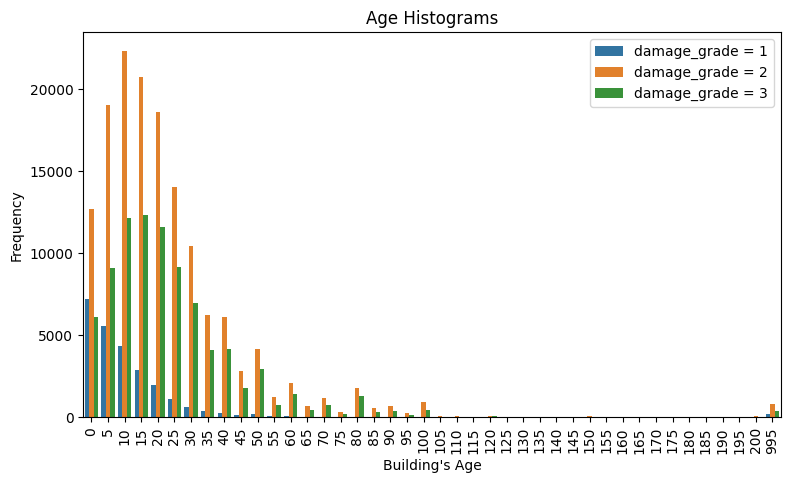

In [19]:
plt.figure(figsize=(9,5))
sns.countplot(x = df_train["age"], hue=df_train["damage_grade"])
plt.ylabel("Frequency")
plt.xlabel("Building's Age")
plt.xticks(rotation=90)
plt.title("Age Histograms")
plt.legend(["damage_grade = 1","damage_grade = 2","damage_grade = 3"])
plt.show()

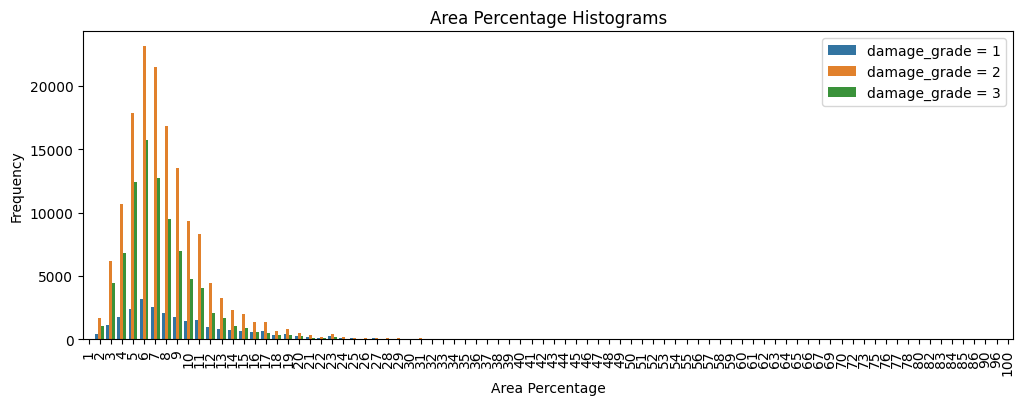

In [23]:
plt.figure(figsize=(12,4))
sns.countplot(x = df_train["area_percentage"], hue=df_train["damage_grade"])
plt.ylabel("Frequency")
plt.xlabel("Area Percentage")
plt.xticks(rotation=90)
plt.title("Area Percentage Histograms")
plt.legend(["damage_grade = 1","damage_grade = 2","damage_grade = 3"])
plt.show()

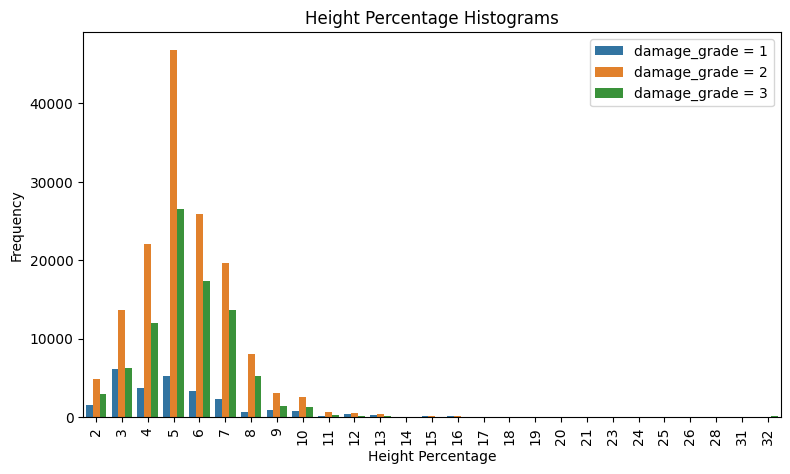

In [24]:
plt.figure(figsize=(9,5))
sns.countplot(x = df_train["height_percentage"], hue=df_train["damage_grade"])
plt.ylabel("Frequency")
plt.xlabel("Height Percentage")
plt.xticks(rotation=90)
plt.title("Height Percentage Histograms")
plt.legend(["damage_grade = 1","damage_grade = 2","damage_grade = 3"])
plt.show()

<Axes: ylabel='count_families'>

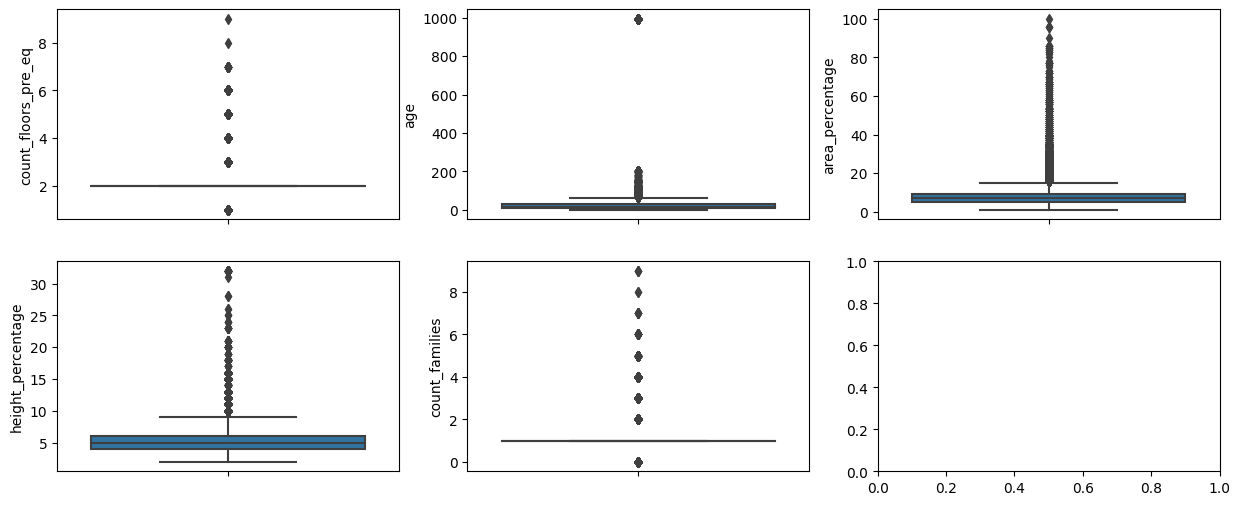

In [31]:
# Checking outliers
_,axss = plt.subplots(2,3, figsize=[15,6])  # create a 2x3 matrix = 6 figures
sns.boxplot(y ='count_floors_pre_eq', data=df_train, ax=axss[0, 0])
sns.boxplot(y ='age', data=df_train, ax=axss[0, 1]) ##!!!
sns.boxplot(y ='area_percentage', data=df_train, ax=axss[0, 2]) ##!!!
sns.boxplot(y ='height_percentage', data=df_train, ax=axss[1][0]) ##!!!
sns.boxplot(y ='count_families', data=df_train, ax=axss[1][1])

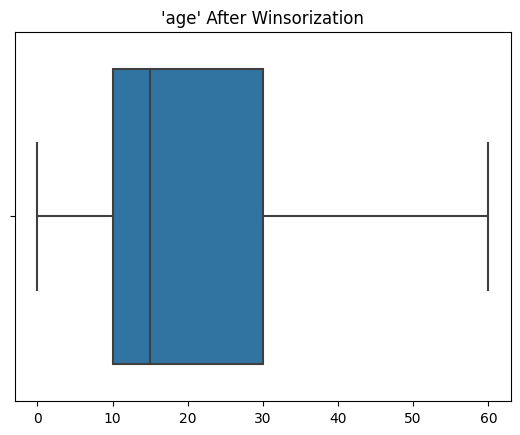

In [32]:
#Winsorization
winsorized_age = winsorize(df_train['age'],limits=(0, 0.05))
#After winsorization
sns.boxplot(x=winsorized_age)
plt.title("'age' After Winsorization")
plt.show()

#Replace data in dataset
df_train['age'] = winsorized_age

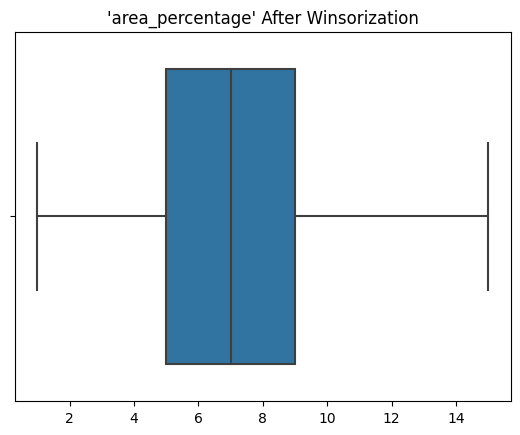

In [33]:
#Winsorization
winsorized_area = winsorize(df_train['area_percentage'],limits=(0, 0.053))

#After winsorization
sns.boxplot(x=winsorized_area)
plt.title("'area_percentage' After Winsorization")
plt.show()

#Replace data in dataset
df_train['area_percentage'] = winsorized_area


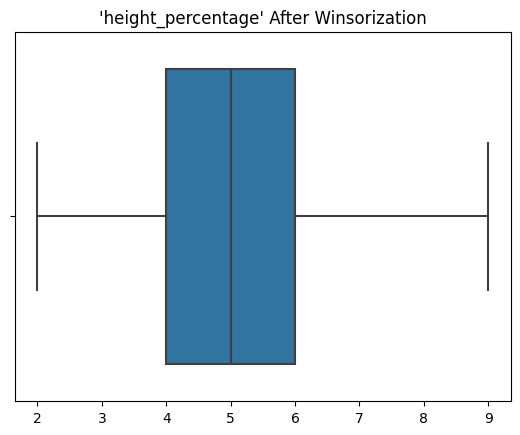

In [34]:
#Winsorization
winsorized_height = winsorize(df_train['height_percentage'],limits=(0, 0.04))

#After winsorization
sns.boxplot(x=winsorized_height)
plt.title("'height_percentage' After Winsorization")
plt.show()

#Replace data in dataset
df_train['height_percentage'] = winsorized_height

In [35]:
# Test set outliers
df3["age"] = winsorize(df3["age"],limits=(0, 0.05))
df3["area_percentage"] = winsorize(df3["area_percentage"],limits=(0, 0.053))
df3["height_percentage"] = winsorize(df3["height_percentage"],limits=(0, 0.04))
df_test = df3

## 3.4 Check class imbalance

<Axes: title={'center': 'Number of Buildings with Each Damage Grade'}>

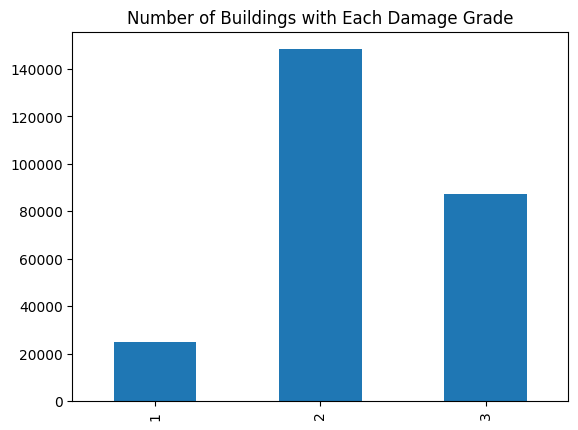

In [36]:
df_y.value_counts().sort_index().plot.bar(title='Number of Buildings with Each Damage Grade')

We can see that class imbalance exists.

# 4. Feature engineering

## 4.1 One-hot encoding

In [37]:
# One-hot encoding: convert category features to numerical features（0 & 1） - spliting into diff columns
columns_onehot = ['land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type',
'position','plan_configuration','legal_ownership_status']

df_train_onehot = pd.get_dummies(df_train,
                            columns = columns_onehot,
                            drop_first = False)      # do not remove a lable to reduce multicollision

df_test_onehot = pd.get_dummies(df_test,
              columns = columns_onehot,
              drop_first = False)

#df_train_onehot.head(2)
df_test_onehot.head(2)


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,0,1,0,...,0,0,0,0,0,0,0,0,1,0
99355,6,141,11987,2,25,13,5,0,1,0,...,0,0,0,0,0,0,0,0,1,0


## 4.2 Correlation analysis and Drop features

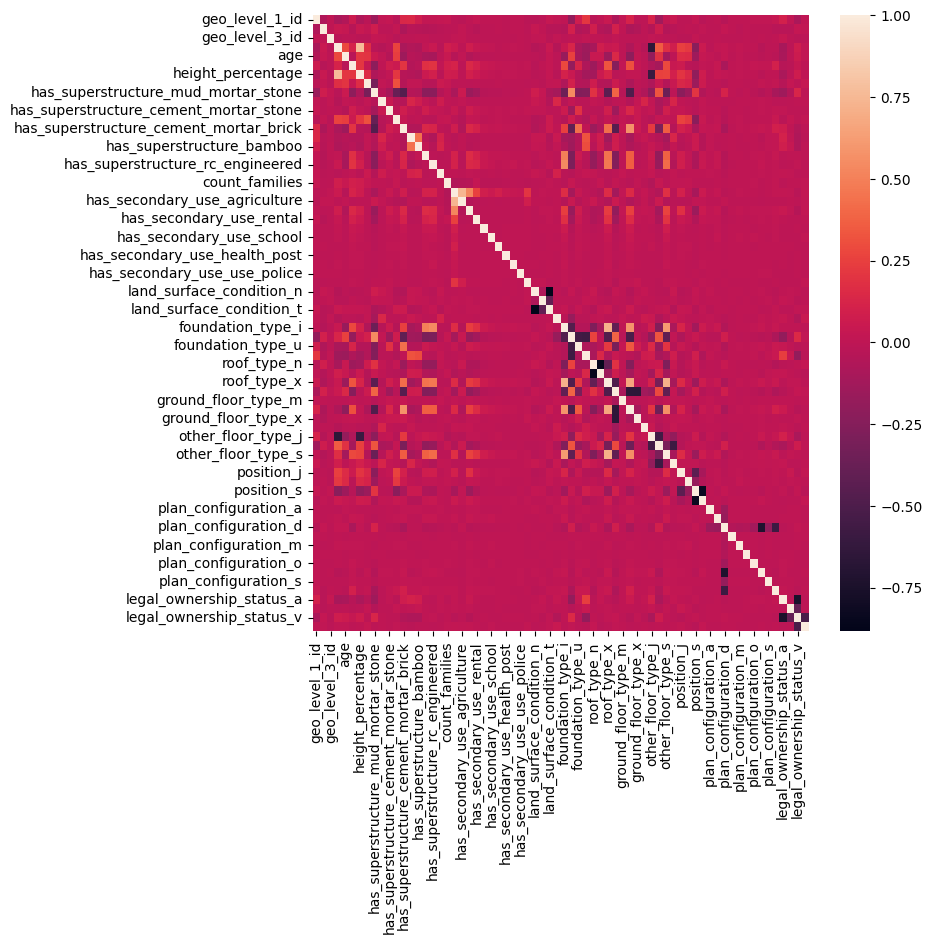

In [38]:
# Correlation matrix
y = df_train_onehot['damage_grade']
X = df_train_onehot.drop(['damage_grade'], axis=1)
corr_matrix = X.corr()

fig1, ax1 = plt.subplots(figsize=(8,8))
sns.heatmap(corr_matrix, ax=ax1)
plt.show()

In [39]:
# Find features that have a high correlation with at least one other feature in the dataset,
# with a correlation coefficient greater than 0.85
threshold = 0.85

relevant_features = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            relevant_features.append(corr_matrix.columns[i])
            break

print(relevant_features)

['land_surface_condition_n', 'roof_type_n']


In [40]:
# Drop those features
# training set
df_train_drop = df_train_onehot.drop(relevant_features, axis=1)

# test set!!
df_test_drop = df_test_onehot.drop(relevant_features, axis=1)

## 4.3 Standardization and PCA

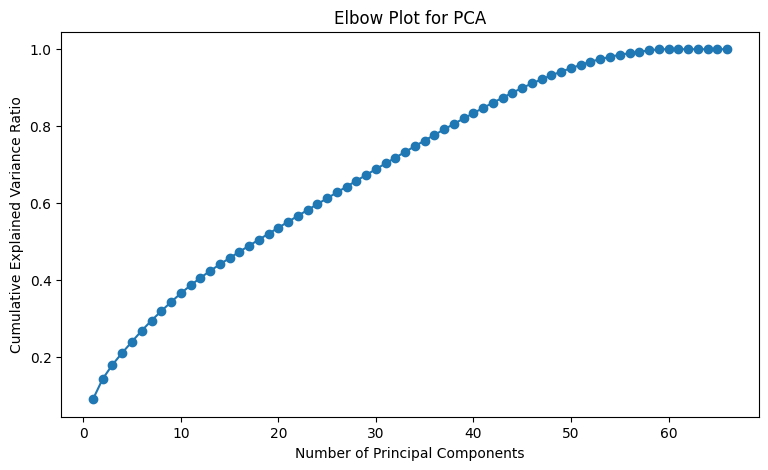

In [41]:
# standardize features
y = df_train_drop['damage_grade']
X = df_train_drop.drop(['damage_grade'], axis=1)

scaler1 = StandardScaler()
df_trainX_std = scaler1.fit_transform(X)
df_trainX_std = pd.DataFrame(df_trainX_std, columns=X.columns,index=X.index)
df_test_std = scaler1.transform(df_test_drop)
df_test_std = pd.DataFrame(df_test_std, columns=df_test_drop.columns,index=df_test_drop.index)

# PCA
pca1 = PCA(n_components = None)
df_train_pca = pca1.fit_transform(df_trainX_std)
df_test_pca = pca1.transform(df_test_std)
explained_variance = pca1.explained_variance_ratio_

cumulative_var_ratio = np.cumsum(pca1.explained_variance_ratio_)
plt.figure(figsize=(9, 5))
plt.plot(range(1,len(cumulative_var_ratio)+1), cumulative_var_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Elbow Plot for PCA')
plt.show()


###Each PC has similar variance. So, we don't use PCA.

# 5. Model selection

In [42]:
# StratifiedKFold
cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=1)

In [43]:
# need to change y from 1,2,3 to 0,1,2
y_new = y - 1

In [44]:
def model_evaluation(model_0, train_scores, test_scores, X, y):
  for i, (train_index, test_index) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model_0 = model_0.fit(X_train, y_train)
    y_pred_train = model_0.predict(X_train)
    y_pred_test = model_0.predict(X_test)
    f1_train = f1_score(y_train, y_pred_train, average='micro')
    f1_test = f1_score(y_test, y_pred_test, average='micro')
    train_scores.append(f1_train)
    test_scores.append(f1_test)
  meanf1_train = np.mean(train_scores)
  meanf1_test = np.mean(test_scores)
  print('micro f1 for training data:',meanf1_train)
  print('------------------------------------------------------------')
  print('micro f1 for test data:',meanf1_test)

## 5.1 Random forest

In [45]:
model_rf = RandomForestClassifier(criterion="gini",
                                  max_features="sqrt",
                                  bootstrap=True,
                                  oob_score=True,
                                  random_state=1,
                                  n_estimators=500,
                                  max_depth = 10
                                  )
train_scores_rf = []
test_scores_rf = []

model_evaluation(model_rf, train_scores_rf, test_scores_rf, X, y_new)

micro f1 for training data: 0.6438712821641353
------------------------------------------------------------
micro f1 for test data: 0.637737381578137


## 5.2 XGBoost


In [46]:
model_xgb = XGBClassifier(booster='gbtree',
                          objective='multi:softmax',
                          num_class=3,
                          n_estimators=1000,
                          learning_rate=0.05,
                          max_depth=10,
                          reg_alpha=0.001,
                          subsample=0.8,
                          colsample_bytree=0.5,
                          tree_method='gpu_hist',
                          eval_metric='mlogloss'
                          )
train_scores_xgb = []
test_scores_xgb = []

model_evaluation(model_xgb, train_scores_xgb, test_scores_xgb, X, y_new)

micro f1 for training data: 0.8548911937956672
------------------------------------------------------------
micro f1 for test data: 0.747821387722821


## 5.3 LightGBM

In [47]:
model_lgbm = LGBMClassifier(boosting_type='gbdt',
                            num_leaves=31,
                            learning_rate=0.1,
                            n_estimators=1000,
                            objective='multiclass',
                            subsample=0.8,
                            colsample_bytree=0.8,
                            reg_alpha=0.1,
                            n_jobs=-1,
                            importance_type='gain'
                            )
train_scores_lgbm = []
test_scores_lgbm = []

model_evaluation(model_lgbm, train_scores_lgbm, test_scores_lgbm, X, y_new)

micro f1 for training data: 0.7880907979515448
------------------------------------------------------------
micro f1 for test data: 0.7427484924498918


## 5.4 CatBoost

In [48]:
model_catb = CatBoostClassifier(
                         learning_rate=0.05,
                         l2_leaf_reg=1.0,
                         rsm=0.8,
                         random_strength=0,
                         max_depth=10,
                         n_estimators=1500,
                         classes_count=3,
                         loss_function='MultiClass',
                         grow_policy='SymmetricTree',
                         verbose=False
                         )
train_scores_catb = []
test_scores_catb = []

model_evaluation(model_catb, train_scores_catb, test_scores_catb, X, y_new)

micro f1 for training data: 0.7996122424327401
------------------------------------------------------------
micro f1 for test data: 0.734993343312965


## 5.5 SVM(linear kernel)

In [ ]:
svc_linear = LinearSVC(C=0.1,
                      penalty='l1',
                      loss='squared_hinge',
                      dual=False,
                      multi_class='ovr',
                      max_iter=5000
                       )

train_scores_svc_linear = []
test_scores_svc_linear = []

model_evaluation(svc_linear, train_scores_svc_linear, test_scores_svc_linear, X, y_new)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


micro f1 for training data: 0.5906280101035837
------------------------------------------------------------
micro f1 for test data: 0.5903469293800276


## 5.6 Multinomial logistic regression

In [ ]:
y_new = y - 1

model_lr = LogisticRegressionCV(cv=5,
                                penalty='l1',
                                scoring='f1_micro',
                                solver='saga',
                                max_iter=3000,
                                n_jobs=-1,
                                multi_class='multinomial',
                                random_state=0
                                )
train_scores_lr = []
test_scores_lr = []

model_evaluation(model_lr, train_scores_lr, test_scores_lr, X, y_new)

# 0.5758907158343086

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# 6. Parameter tuning

In [52]:
X_test = df_test_drop

In [74]:
submission_format = pd.read_csv('/content/drive/MyDrive/CSCI567/submission_format.csv', index_col='building_id')

we choose XGBoost, LightGBM, and CatBoost

## 6.1.1 XGBoost

In [19]:
def xgb_objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(X, y_new, test_size=0.2,random_state=0)
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0)
    }
    xgb = XGBClassifier(**param,
                      booster='gbtree',
                      objective='multi:softmax',
                      num_class=3,
                      tree_method='gpu_hist',
                      eval_metric='mlogloss',
                      early_stopping_rounds=300
                    )
    xgb.fit(train_x, train_y,eval_set=[(test_x,test_y)], verbose=0)
    pred_labels = xgb.predict(test_x)
    f1_xgb = f1_score(test_y, pred_labels, average='micro')
    return f1_xgb

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(xgb_objective, n_trials=50)

print('Number of finished trials:', len(study_xgb.trials))
print('Best trial:', study_xgb.best_trial.params)

[I 2023-07-19 04:32:35,992] A new study created in memory with name: no-name-f13e36f9-0e88-45d6-9dbd-49d3b46c01a3
[I 2023-07-19 04:32:55,531] Trial 0 finished with value: 0.7456879184973427 and parameters: {'learning_rate': 0.18727765793981935, 'n_estimators': 2202, 'max_depth': 6, 'reg_alpha': 3.724859674195116e-05, 'colsample_bytree': 0.9198150980418456, 'subsample': 0.8857342213244368}. Best is trial 0 with value: 0.7456879184973427.
[I 2023-07-19 04:33:15,477] Trial 1 finished with value: 0.7427140691851654 and parameters: {'learning_rate': 0.19914213577670625, 'n_estimators': 2179, 'max_depth': 10, 'reg_alpha': 0.05933218854301189, 'colsample_bytree': 0.7457578021520546, 'subsample': 0.5280200707691602}. Best is trial 0 with value: 0.7456879184973427.
[I 2023-07-19 04:33:42,844] Trial 2 finished with value: 0.7458989658678844 and parameters: {'learning_rate': 0.09145385662794703, 'n_estimators': 2806, 'max_depth': 7, 'reg_alpha': 0.5251151757869024, 'colsample_bytree': 0.896296182

Number of finished trials: 50
Best trial: {'learning_rate': 0.017346885513848748, 'n_estimators': 1550, 'max_depth': 11, 'reg_alpha': 6.15864249387113e-05, 'colsample_bytree': 0.8769225093489029, 'subsample': 0.829237804768505}


In [21]:
# get 2 best params
best_params_xgb1 = {'learning_rate': 0.017346885513848748, 'n_estimators': 1550, 'max_depth': 11, 'reg_alpha': 6.15864249387113e-05, 'colsample_bytree': 0.8769225093489029, 'subsample': 0.829237804768505}
# 1550 -> ?
best_params_xgb2 = {'learning_rate': 0.03467053985279808, 'n_estimators': 1877, 'max_depth': 10, 'reg_alpha': 1.2980658054156848e-05, 'colsample_bytree': 0.7689946728808666, 'subsample': 0.755867039100733}
# 1877 -> ?

In [20]:
# find best iteration for best1
train_x1, test_x1, train_y1, test_y1 = train_test_split(X, y_new, test_size=0.2,random_state=0)
best_params_xgb1 = {'learning_rate': 0.017346885513848748, 'n_estimators': 1550, 'max_depth': 11, 'reg_alpha': 6.15864249387113e-05, 'colsample_bytree': 0.8769225093489029, 'subsample': 0.829237804768505}
# 1550 -> ?
xgb_best1 = XGBClassifier(**best_params_xgb1,
                  booster='gbtree',
                  objective='multi:softmax',
                  num_class=3,
                  tree_method='gpu_hist',
                  eval_metric='mlogloss',
                  early_stopping_rounds=300
                    )
xgb_best1.fit(train_x1, train_y1,eval_set=[(test_x1,test_y1)], verbose=0)
pred_labels1 = xgb_best1.predict(test_x1)
f1_xgb1 = f1_score(test_y1, pred_labels1, average='micro')
print(f1_xgb1)
print(xgb_best1.best_iteration)

0.7496018879146601
1549


In [50]:
# cv for best1
best_params_xgb1 = {'learning_rate': 0.017346885513848748, 'n_estimators': 1549, 'max_depth': 11, 'reg_alpha': 6.15864249387113e-05, 'colsample_bytree': 0.8769225093489029, 'subsample': 0.829237804768505}
# 1550 -> 1549

xgb_best1 = XGBClassifier(**best_params_xgb1,
                  booster='gbtree',
                  objective='multi:softmax',
                  num_class=3,
                  tree_method='gpu_hist',
                  eval_metric='mlogloss'
                    )
train_scores_xgb_best1 = []
test_scores_xgb_best1 = []
# cv
model_evaluation(xgb_best1, train_scores_xgb_best1, test_scores_xgb_best1, X, y_new)

# 0.7484391919782032

micro f1 for training data: 0.8603401365811838
------------------------------------------------------------
micro f1 for test data: 0.7484391919782032


In [53]:
# 1st best!! (increase 'n_estimators')
best_params_xgb1 = {'learning_rate': 0.017346885513848748, 'n_estimators': 1936, 'max_depth': 11, 'reg_alpha': 6.15864249387113e-05, 'colsample_bytree': 0.8769225093489029, 'subsample': 0.829237804768505}
# 1550 -> 1549 -> 1936

xgb_raw1 = XGBClassifier(**best_params_xgb1,
                  booster='gbtree',
                  objective='multi:softmax',
                  num_class=3,
                  tree_method='gpu_hist',
                  eval_metric='mlogloss'
                    )

xgb_raw1.fit(X, y_new)

y_pred_xgb_test1 = xgb_raw1.predict(X_test) #!!
y_pred_xgb_test1 = y_pred_xgb_test1 + 1

submission_xgb1 = pd.DataFrame(data=y_pred_xgb_test1,
                             columns=submission_format.columns,
                             index=submission_format.index)
submission_xgb1.to_csv('xgb1.csv')
# 0.7497

In [39]:
# find best iteration for best2
train_x1, test_x1, train_y1, test_y1 = train_test_split(X, y_new, test_size=0.2,random_state=0)
best_params_xgb2 = {'learning_rate': 0.03467053985279808, 'n_estimators': 1877, 'max_depth': 10, 'reg_alpha': 1.2980658054156848e-05, 'colsample_bytree': 0.7689946728808666, 'subsample': 0.755867039100733}
# 1877 -> ?
xgb_best2 = XGBClassifier(**best_params_xgb2,
                  booster='gbtree',
                  objective='multi:softmax',
                  num_class=3,
                  tree_method='gpu_hist',
                  eval_metric='mlogloss',
                  early_stopping_rounds=300
                    )
xgb_best2.fit(train_x1, train_y1,eval_set=[(test_x1,test_y1)], verbose=0)
pred_labels2 = xgb_best2.predict(test_x1)
f1_xgb2 = f1_score(test_y1, pred_labels2, average='micro')
print(f1_xgb2)
print(xgb_best2.best_iteration)

0.7493332821703343
1102


In [54]:
# cv for best2
best_params_xgb2 = {'learning_rate': 0.03467053985279808, 'n_estimators': 1102, 'max_depth': 10, 'reg_alpha': 1.2980658054156848e-05, 'colsample_bytree': 0.7689946728808666, 'subsample': 0.755867039100733}
# 1877 -> 1102

xgb_best2 = XGBClassifier(**best_params_xgb2,
                  booster='gbtree',
                  objective='multi:softmax',
                  num_class=3,
                  tree_method='gpu_hist',
                  eval_metric='mlogloss'
                    )
train_scores_xgb_best2 = []
test_scores_xgb_best2 = []
# cv
model_evaluation(xgb_best2, train_scores_xgb_best2, test_scores_xgb_best2, X, y_new)

# 0.7480823246126483

micro f1 for training data: 0.8533764253913712
------------------------------------------------------------
micro f1 for test data: 0.7480823246126483


In [55]:
# 2nd best!! (increase 'n_estimators')
best_params_xgb2 = {'learning_rate': 0.03467053985279808, 'n_estimators': 1377, 'max_depth': 10, 'reg_alpha': 1.2980658054156848e-05, 'colsample_bytree': 0.7689946728808666, 'subsample': 0.755867039100733}
# 1877 -> 1102 -> 1377

xgb_raw2 = XGBClassifier(**best_params_xgb2,
                  booster='gbtree',
                  objective='multi:softmax',
                  num_class=3,
                  tree_method='gpu_hist',
                  eval_metric='mlogloss'
                    )

xgb_raw2.fit(X, y_new)

y_pred_xgb_test2 = xgb_raw2.predict(X_test) #!!
y_pred_xgb_test2 = y_pred_xgb_test2 + 1

submission_xgb2 = pd.DataFrame(data=y_pred_xgb_test2,
                             columns=submission_format.columns,
                             index=submission_format.index)
submission_xgb2.to_csv('xgb2.csv')
# 0.7487

## 6.1.2 XGBoost + SMOTE
Use SMOTE to pre-process data to compensate for class imbalance(on raw features)

In [57]:
unique_labels, label_counts = np.unique(y_new, return_counts=True)
label_counts_df = pd.DataFrame({'label': unique_labels, 'count': label_counts})
print(label_counts_df)

   label   count
0      0   25124
1      1  148259
2      2   87218


In [58]:
smo = SMOTE(sampling_strategy={0:47095,1:148259,2:87218}, random_state=1) #label0=(label1+label2)/5
X_smo,y_new_smo =smo.fit_resample(pd.DataFrame(X), list(y_new))


In [27]:
def xgb_smo_objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(X_smo, y_new_smo, test_size=0.2,random_state=0)
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0)
    }
    xgb_smo = XGBClassifier(**param,
                      booster='gbtree',
                      objective='multi:softmax',
                      num_class=3,
                      tree_method='gpu_hist',
                      eval_metric='mlogloss',
                      early_stopping_rounds=300
                    )
    xgb_smo.fit(train_x, train_y,eval_set=[(test_x,test_y)], verbose=0)
    pred_labels = xgb_smo.predict(test_x)
    f1_xgb_smo = f1_score(test_y, pred_labels, average='micro')
    return f1_xgb_smo

study_xgb_smo = optuna.create_study(direction='maximize')
study_xgb_smo.optimize(xgb_smo_objective, n_trials=50)

print('Number of finished trials:', len(study_xgb_smo.trials))
print('Best trial:', study_xgb_smo.best_trial.params)
#

[I 2023-07-19 06:13:23,612] A new study created in memory with name: no-name-7125f7f5-6ae6-44d6-b6de-f2d913cd0d4e
[I 2023-07-19 06:13:53,178] Trial 0 finished with value: 0.761302309121472 and parameters: {'learning_rate': 0.1643890976959765, 'n_estimators': 2568, 'max_depth': 4, 'reg_alpha': 0.1216706022876549, 'colsample_bytree': 0.9739024258545534, 'subsample': 0.886019301926262}. Best is trial 0 with value: 0.761302309121472.
[I 2023-07-19 06:15:28,537] Trial 1 finished with value: 0.7652658586216049 and parameters: {'learning_rate': 0.013257422973100896, 'n_estimators': 2912, 'max_depth': 9, 'reg_alpha': 0.0006086595260405795, 'colsample_bytree': 0.792233209776873, 'subsample': 0.5496054439762312}. Best is trial 1 with value: 0.7652658586216049.
[I 2023-07-19 06:15:45,863] Trial 2 finished with value: 0.7646288595947979 and parameters: {'learning_rate': 0.21443530624344256, 'n_estimators': 2894, 'max_depth': 7, 'reg_alpha': 0.0016486810971376288, 'colsample_bytree': 0.944154956061

Number of finished trials: 50
Best trial: {'learning_rate': 0.03559203576734761, 'n_estimators': 2096, 'max_depth': 9, 'reg_alpha': 0.004653908666924504, 'colsample_bytree': 0.7627950008653521, 'subsample': 0.9542948474390538}


In [ ]:
# get 3 best params
best_params_xgb_smo1 = {'learning_rate': 0.03559203576734761, 'n_estimators': 2096, 'max_depth': 9, 'reg_alpha': 0.004653908666924504, 'colsample_bytree': 0.7627950008653521, 'subsample': 0.9542948474390538}
# 2096 -> ?
best_params_xgb_smo2 = {'learning_rate': 0.04075921308267704, 'n_estimators': 2204, 'max_depth': 10, 'reg_alpha': 0.0021679861415337337, 'colsample_bytree': 0.7426273773691311, 'subsample': 0.8509433161738038}
# 2204 -> ?
best_params_xgb_smo3 = {'learning_rate': 0.0323677327359839, 'n_estimators': 2326, 'max_depth': 9, 'reg_alpha': 0.0001915742662671955, 'colsample_bytree': 0.7883220623448634, 'subsample': 0.888497504945749}
# 2326 -> ?

In [20]:
# find best iteration for best1
train_x1_smo, test_x1_smo, train_y1_smo, test_y1_smo = train_test_split(X_smo, y_new_smo, test_size=0.2,random_state=0)
best_params_xgb_smo1 = {'learning_rate': 0.03559203576734761, 'n_estimators': 2096, 'max_depth': 9, 'reg_alpha': 0.004653908666924504, 'colsample_bytree': 0.7627950008653521, 'subsample': 0.9542948474390538}
# 2096 -> ?
xgb_best_smo1 = XGBClassifier(**best_params_xgb_smo1,
                  booster='gbtree',
                  objective='multi:softmax',
                  num_class=3,
                  tree_method='gpu_hist',
                  eval_metric='mlogloss',
                  early_stopping_rounds=300
                    )
xgb_best_smo1.fit(train_x1_smo, train_y1_smo,eval_set=[(test_x1_smo,test_y1_smo)], verbose=0)
pred_labels_smo1 = xgb_best_smo1.predict(test_x1_smo)
f1_xgb_smo1 = f1_score(test_y1_smo, pred_labels_smo1, average='micro')
print(f1_xgb_smo1)
print(xgb_best_smo1.best_iteration)

0.7693532690436168
1956


In [59]:
# cv for best1
best_params_xgb_smo1 = {'learning_rate': 0.03559203576734761, 'n_estimators': 1956, 'max_depth': 9, 'reg_alpha': 0.004653908666924504, 'colsample_bytree': 0.7627950008653521, 'subsample': 0.9542948474390538}
# 2096 -> 1956

xgb_best_smo1 = XGBClassifier(**best_params_xgb_smo1,
                  booster='gbtree',
                  objective='multi:softmax',
                  num_class=3,
                  tree_method='gpu_hist',
                  eval_metric='mlogloss'
                    )
train_scores_xgb_smo_best1 = []
test_scores_xgb_smo_best1 = []
# cv
y_new_smo = pd.Series(y_new_smo)
model_evaluation(xgb_best_smo1, train_scores_xgb_smo_best1, test_scores_xgb_smo_best1, X_smo, y_new_smo)

# 0.7661622577325181

micro f1 for training data: 0.8668719835591769
------------------------------------------------------------
micro f1 for test data: 0.7661622577325181


In [61]:
# cv for best1 fit(X, y_new)
train_scores_xgb_smo_best1 = []
test_scores_xgb_smo_best1 = []
# cv
model_evaluation(xgb_best_smo1, train_scores_xgb_smo_best1, test_scores_xgb_smo_best1, X, y_new)

# 0.7479710417769692

micro f1 for training data: 0.8600130084173928
------------------------------------------------------------
micro f1 for test data: 0.7479710417769692


In [62]:
# 1st best!! fit(X_smo, y_new_smo)
best_params_xgb_smo1 = {'learning_rate': 0.03559203576734761, 'n_estimators': 1956, 'max_depth': 9, 'reg_alpha': 0.004653908666924504, 'colsample_bytree': 0.7627950008653521, 'subsample': 0.9542948474390538}
# 2096 -> 1956!!
xgb_smo1 = XGBClassifier(**best_params_xgb_smo1,
                  booster='gbtree',
                  objective='multi:softmax',
                  num_class=3,
                  tree_method='gpu_hist',
                  eval_metric='mlogloss'
                    )

xgb_smo1.fit(X_smo, y_new_smo)

y_pred_xgb_smo_test1 = xgb_smo1.predict(X_test) #!!
y_pred_xgb_smo_test1 = y_pred_xgb_smo_test1 + 1

submission_xgb_smo1 = pd.DataFrame(data=y_pred_xgb_smo_test1,
                             columns=submission_format.columns,
                             index=submission_format.index)
submission_xgb_smo1.to_csv('xgb_smo1.csv')
# 0.7482

In [63]:
# 1st best!! fit(X, y_new)
best_params_xgb_smo1 = {'learning_rate': 0.03559203576734761, 'n_estimators': 1956, 'max_depth': 9, 'reg_alpha': 0.004653908666924504, 'colsample_bytree': 0.7627950008653521, 'subsample': 0.9542948474390538}
# from 2096 to 1956!!
xgb_smo1_1 = XGBClassifier(**best_params_xgb_smo1,
                  booster='gbtree',
                  objective='multi:softmax',
                  num_class=3,
                  tree_method='gpu_hist',
                  eval_metric='mlogloss'
                    )

xgb_smo1_1.fit(X, y_new)

y_pred_xgb_smo_test1_1 = xgb_smo1_1.predict(X_test) #!!
y_pred_xgb_smo_test1_1 = y_pred_xgb_smo_test1_1 + 1

submission_xgb_smo1_1 = pd.DataFrame(data=y_pred_xgb_smo_test1_1,
                             columns=submission_format.columns,
                             index=submission_format.index)
submission_xgb_smo1_1.to_csv('xgb_smo1_1.csv')
# 0.7492

In [46]:
# find best iteration for best2
train_x1_smo, test_x1_smo, train_y1_smo, test_y1_smo = train_test_split(X_smo, y_new_smo, test_size=0.2,random_state=0)
best_params_xgb_smo2 = {'learning_rate': 0.04075921308267704, 'n_estimators': 2204, 'max_depth': 10, 'reg_alpha': 0.0021679861415337337, 'colsample_bytree': 0.7426273773691311, 'subsample': 0.8509433161738038}
# 2204 ->
xgb_best_smo2 = XGBClassifier(**best_params_xgb_smo2,
                  booster='gbtree',
                  objective='multi:softmax',
                  num_class=3,
                  tree_method='gpu_hist',
                  eval_metric='mlogloss',
                  early_stopping_rounds=300
                    )
xgb_best_smo2.fit(train_x1_smo, train_y1_smo,eval_set=[(test_x1_smo,test_y1_smo)], verbose=0)
pred_labels_smo2 = xgb_best_smo2.predict(test_x1_smo)
f1_xgb_smo2 = f1_score(test_y1_smo, pred_labels_smo2, average='micro')
print(f1_xgb_smo2)
print(xgb_best_smo2.best_iteration)

0.7692647969565601
1189


In [64]:
# cv for best2
best_params_xgb_smo2 = {'learning_rate': 0.04075921308267704, 'n_estimators': 1189, 'max_depth': 10, 'reg_alpha': 0.0021679861415337337, 'colsample_bytree': 0.7426273773691311, 'subsample': 0.8509433161738038}
# 2204 -> 1189

xgb_best_smo2 = XGBClassifier(**best_params_xgb_smo2,
                  booster='gbtree',
                  objective='multi:softmax',
                  num_class=3,
                  tree_method='gpu_hist',
                  eval_metric='mlogloss'
                    )
train_scores_xgb_smo_best2 = []
test_scores_xgb_smo_best2 = []
# cv
y_new_smo = pd.Series(y_new_smo)
model_evaluation(xgb_best_smo2, train_scores_xgb_smo_best2, test_scores_xgb_smo_best2, X_smo, y_new_smo)

# 0.7665550774309853

micro f1 for training data: 0.875129170547428
------------------------------------------------------------
micro f1 for test data: 0.7665550774309853


In [65]:
# cv for best2 fit(X, y_new)
train_scores_xgb_smo_best2 = []
test_scores_xgb_smo_best2 = []
# cv
model_evaluation(xgb_best_smo2, train_scores_xgb_smo_best2, test_scores_xgb_smo_best2, X, y_new)

# 0.7480209240075889

micro f1 for training data: 0.8694920583559751
------------------------------------------------------------
micro f1 for test data: 0.7480209240075889


In [66]:
# 2nd best!! (increase 'n_estimators') fit(X_smo, y_new_smo)
best_params_xgb_smo2 = {'learning_rate': 0.04075921308267704, 'n_estimators': 1486, 'max_depth': 10, 'reg_alpha': 0.0021679861415337337, 'colsample_bytree': 0.7426273773691311, 'subsample': 0.8509433161738038}
# 2204 -> 1189 -> 1486
xgb_smo2 = XGBClassifier(**best_params_xgb_smo2,
                  booster='gbtree',
                  objective='multi:softmax',
                  num_class=3,
                  tree_method='gpu_hist',
                  eval_metric='mlogloss'
                    )

xgb_smo2.fit(X_smo, y_new_smo)

y_pred_xgb_smo_test2 = xgb_smo2.predict(X_test) #!!
y_pred_xgb_smo_test2 = y_pred_xgb_smo_test2 + 1

submission_xgb_smo2 = pd.DataFrame(data=y_pred_xgb_smo_test2,
                             columns=submission_format.columns,
                             index=submission_format.index)
submission_xgb_smo2.to_csv('xgb_smo2.csv')
# 0.7482

In [67]:
# 2nd best!! (increase 'n_estimators') fit(X, y_new)
best_params_xgb_smo2 = {'learning_rate': 0.04075921308267704, 'n_estimators': 1486, 'max_depth': 10, 'reg_alpha': 0.0021679861415337337, 'colsample_bytree': 0.7426273773691311, 'subsample': 0.8509433161738038}
# 2204 -> 1189 -> 1486
xgb_smo2_1 = XGBClassifier(**best_params_xgb_smo2,
                  booster='gbtree',
                  objective='multi:softmax',
                  num_class=3,
                  tree_method='gpu_hist',
                  eval_metric='mlogloss'
                    )

xgb_smo2_1.fit(X, y_new)

y_pred_xgb_smo_test2_1 = xgb_smo2_1.predict(X_test) #!!
y_pred_xgb_smo_test2_1 = y_pred_xgb_smo_test2_1 + 1

submission_xgb_smo2_1 = pd.DataFrame(data=y_pred_xgb_smo_test2_1,
                             columns=submission_format.columns,
                             index=submission_format.index)
submission_xgb_smo2_1.to_csv('xgb_smo2_1.csv')
# 0.7488

In [54]:
# find best iteration for best3
train_x1_smo, test_x1_smo, train_y1_smo, test_y1_smo = train_test_split(X_smo, y_new_smo, test_size=0.2,random_state=0)
best_params_xgb_smo3 = {'learning_rate': 0.0323677327359839, 'n_estimators': 3000, 'max_depth': 9, 'reg_alpha': 0.0001915742662671955, 'colsample_bytree': 0.7883220623448634, 'subsample': 0.888497504945749}
# 2326(3000) ->
xgb_best_smo3 = XGBClassifier(**best_params_xgb_smo3,
                  booster='gbtree',
                  objective='multi:softmax',
                  num_class=3,
                  tree_method='gpu_hist',
                  eval_metric='mlogloss',
                  early_stopping_rounds=300
                    )
xgb_best_smo3.fit(train_x1_smo, train_y1_smo,eval_set=[(test_x1_smo,test_y1_smo)], verbose=0)
pred_labels_smo3 = xgb_best_smo3.predict(test_x1_smo)
f1_xgb_smo3 = f1_score(test_y1_smo, pred_labels_smo3, average='micro')
print(f1_xgb_smo3)
print(xgb_best_smo3.best_iteration)

0.7689816862779792
2080


In [68]:
# cv for best3
best_params_xgb_smo3 = {'learning_rate': 0.0323677327359839, 'n_estimators': 2080, 'max_depth': 9, 'reg_alpha': 0.0001915742662671955, 'colsample_bytree': 0.7883220623448634, 'subsample': 0.888497504945749}
# 2326(3000) -> 2080
xgb_best_smo3 = XGBClassifier(**best_params_xgb_smo3,
                  booster='gbtree',
                  objective='multi:softmax',
                  num_class=3,
                  tree_method='gpu_hist',
                  eval_metric='mlogloss'
                    )
train_scores_xgb_smo_best3 = []
test_scores_xgb_smo_best3 = []
# cv
y_new_smo = pd.Series(y_new_smo)
model_evaluation(xgb_best_smo3, train_scores_xgb_smo_best3, test_scores_xgb_smo_best3, X_smo, y_new_smo)

# 0.7667921840019278

micro f1 for training data: 0.8692598705456845
------------------------------------------------------------
micro f1 for test data: 0.7667921840019278


In [69]:
# cv for best3 fit(X, y_new)
train_scores_xgb_smo_best3 = []
test_scores_xgb_smo_best3 = []
# cv
model_evaluation(xgb_best_smo3, train_scores_xgb_smo_best3, test_scores_xgb_smo_best3, X, y_new)

# 0.7481360439945641

micro f1 for training data: 0.8629245474951637
------------------------------------------------------------
micro f1 for test data: 0.7481360439945641


In [70]:
# 3rd best!! fit(X_smo, y_new_smo)
best_params_xgb_smo3 = {'learning_rate': 0.0323677327359839, 'n_estimators': 2080, 'max_depth': 9, 'reg_alpha': 0.0001915742662671955, 'colsample_bytree': 0.7883220623448634, 'subsample': 0.888497504945749}
# 2326 -> 2080!!
xgb_smo3 = XGBClassifier(**best_params_xgb_smo3,
                  booster='gbtree',
                  objective='multi:softmax',
                  num_class=3,
                  tree_method='gpu_hist',
                  eval_metric='mlogloss'
                    )

xgb_smo3.fit(X_smo, y_new_smo)

y_pred_xgb_smo_test3 = xgb_smo3.predict(X_test) #!!
y_pred_xgb_smo_test3 = y_pred_xgb_smo_test3 + 1

submission_xgb_smo3 = pd.DataFrame(data=y_pred_xgb_smo_test3,
                             columns=submission_format.columns,
                             index=submission_format.index)
submission_xgb_smo3.to_csv('xgb_smo3.csv')
# 0.7484

In [71]:
# 3rd best!! fit(X, y_new)
best_params_xgb_smo3 = {'learning_rate': 0.0323677327359839, 'n_estimators': 2080, 'max_depth': 9, 'reg_alpha': 0.0001915742662671955, 'colsample_bytree': 0.7883220623448634, 'subsample': 0.888497504945749}
# 2326 -> 2080!!
xgb_smo3_1 = XGBClassifier(**best_params_xgb_smo3,
                  booster='gbtree',
                  objective='multi:softmax',
                  num_class=3,
                  tree_method='gpu_hist',
                  eval_metric='mlogloss'
                    )

xgb_smo3_1.fit(X, y_new)

y_pred_xgb_smo_test3_1 = xgb_smo3_1.predict(X_test) #!!
y_pred_xgb_smo_test3_1 = y_pred_xgb_smo_test3_1 + 1

submission_xgb_smo3_1 = pd.DataFrame(data=y_pred_xgb_smo_test3_1,
                             columns=submission_format.columns,
                             index=submission_format.index)
submission_xgb_smo3_1.to_csv('xgb_smo3_1.csv')
# 0.7494

## 6.2 LightGBM

In [51]:
def lgbm_objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(X, y_new, test_size=0.2,random_state=0)
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 10000),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-6, 100.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 100.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 500),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 100, 3000)
    }
    lgbm = LGBMClassifier(**param,
                        boosting_type='gbdt',
                        #class_weight='balanced',
                        objective='multiclass',
                        importance_type='gain',
                        n_jobs=-1
                        )
    lgbm.fit(train_x, train_y,eval_set=[(test_x,test_y)],eval_metric='softmax',
             callbacks=[lightgbm.early_stopping(stopping_rounds=300, verbose=False)])
    pred_labels = lgbm.predict(test_x)
    f1_lgbm = f1_score(test_y, pred_labels, average='micro')
    return f1_lgbm

study_lgbm = optuna.create_study(direction='maximize')#sampler=optuna.samplers.TPESampler()
study_lgbm.optimize(lgbm_objective, n_trials=50)

print('Number of finished trials:', len(study_lgbm.trials))
print('Best trial:', study_lgbm.best_trial.params)

[I 2023-07-13 18:05:17,528] A new study created in memory with name: no-name-dbf04deb-acd6-4941-87da-e816c3f9f34f
[I 2023-07-13 18:10:02,808] Trial 0 finished with value: 0.7061453157076802 and parameters: {'learning_rate': 0.20547007724265173, 'n_estimators': 7941, 'reg_alpha': 2.1733037623194524e-06, 'reg_lambda': 0.007017843933302726, 'num_leaves': 323, 'colsample_bytree': 0.22104921070581607, 'subsample': 0.12877946744204016, 'subsample_freq': 8, 'min_child_samples': 2953}. Best is trial 0 with value: 0.7061453157076802.
[I 2023-07-13 18:12:22,808] Trial 1 finished with value: 0.7395867308762303 and parameters: {'learning_rate': 0.261865744653741, 'n_estimators': 8676, 'reg_alpha': 0.6166084027059338, 'reg_lambda': 4.065177752836118, 'num_leaves': 165, 'colsample_bytree': 0.24075536692530292, 'subsample': 0.8760852446947205, 'subsample_freq': 3, 'min_child_samples': 1173}. Best is trial 1 with value: 0.7395867308762303.
[I 2023-07-13 18:15:07,681] Trial 2 finished with value: 0.739

Number of finished trials: 50
Best trial: {'learning_rate': 0.10315109529721578, 'n_estimators': 2708, 'reg_alpha': 0.7522397931038659, 'reg_lambda': 8.859106416855032e-05, 'num_leaves': 330, 'colsample_bytree': 0.7710487881722415, 'subsample': 0.7832336808768992, 'subsample_freq': 8, 'min_child_samples': 108}


In [72]:
# find best iteration for lightgbm
train_x1, test_x1, train_y1, test_y1 = train_test_split(X, y_new, test_size=0.2,random_state=0)
best_params_lgbm1 = {'learning_rate': 0.10315109529721578, 'n_estimators': 2708, 'reg_alpha': 0.7522397931038659, 'reg_lambda': 8.859106416855032e-05, 'num_leaves': 330, 'colsample_bytree': 0.7710487881722415, 'subsample': 0.7832336808768992, 'subsample_freq': 8, 'min_child_samples': 108}
# 2708 -> ?
lgbm_best1 = LGBMClassifier(**best_params_lgbm1,
                        boosting_type='gbdt',
                        objective='multiclass',
                        importance_type='gain',
                        n_jobs=-1
                        )
lgbm_best1.fit(train_x1, train_y1,eval_set=[(test_x1,test_y1)],eval_metric='softmax',
             callbacks=[lightgbm.early_stopping(stopping_rounds=300, verbose=False)])
pred_labels1 = lgbm_best1.predict(test_x1)
f1_lgbm1 = f1_score(test_y1, pred_labels1, average='micro')
print(f1_lgbm1)
print(lgbm_best1.best_iteration_)

0.7468198998484298
209


In [73]:
# cv for lightgbm
best_params_lgbm = {'learning_rate': 0.10315109529721578, 'n_estimators': 209, 'reg_alpha': 0.7522397931038659, 'reg_lambda': 8.859106416855032e-05, 'num_leaves': 330, 'colsample_bytree': 0.7710487881722415, 'subsample': 0.7832336808768992, 'subsample_freq': 8, 'min_child_samples': 108}
# 2708 -> 209
lgbm_best = LGBMClassifier(**best_params_lgbm,
                        boosting_type='gbdt',
                        objective='multiclass',
                        importance_type='gain',
                        n_jobs=-1
                        )

train_scores_lgbm_best = []
test_scores_lgbm_best = []
# cv
model_evaluation(lgbm_best, train_scores_lgbm_best, test_scores_lgbm_best, X, y_new)
# 0.7453501781372033

micro f1 for training data: 0.8221179119000238
------------------------------------------------------------
micro f1 for test data: 0.7453501781372033


In [80]:
# best lightgbm
best_params_lgbm = {'learning_rate': 0.10315109529721578, 'n_estimators': 209, 'reg_alpha': 0.7522397931038659, 'reg_lambda': 8.859106416855032e-05, 'num_leaves': 330, 'colsample_bytree': 0.7710487881722415, 'subsample': 0.7832336808768992, 'subsample_freq': 8, 'min_child_samples': 108}
# 2708 -> 209!!
lgbm_final = LGBMClassifier(**best_params_lgbm,
                        boosting_type='gbdt',
                        #class_weight='balanced',
                        objective='multiclass',
                        importance_type='gain',
                        n_jobs=-1
                        )
lgbm_final.fit(X, y_new)

y_pred_lgbm_test = lgbm_final.predict(X_test) #!!
y_pred_lgbm_test = y_pred_lgbm_test + 1

submission_lgbm = pd.DataFrame(data=y_pred_lgbm_test,
                             columns=submission_format.columns,
                             index=submission_format.index)

submission_lgbm.to_csv('lgbm.csv')
# 0.7470

## 6.3 CatBoost

In [30]:
def catb_objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(X, y_new, test_size=0.2,random_state=0)
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.4),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 5000),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'random_strength': trial.suggest_float('random_strength', 0, 5.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 1000.0),
        'border_count':trial.suggest_int('border_count',64,254),
        #'model_shrink_rate':trial.suggest_float('model_shrink_rate',0.00001,0.5),
        #'penalties_coefficient':trial.suggest_float('penalties_coefficient',1e-5, 100.0, log=True),
        'rsm': trial.suggest_float('rsm', 0.1, 1.0),
        'bagging_temperature':trial.suggest_float('bagging_temperature', 0, 10),
        #'grow_policy':trial.suggest_categorical('grow_policy',['SymmetricTree','Depthwise'])
        }

    catb = CatBoostClassifier(**param,
                         loss_function='MultiClass',
                         #auto_class_weights='Balanced',
                         grow_policy='Depthwise',
                         verbose=False,
                         classes_count=3
                         )
    catb.fit(train_x, train_y,eval_set=[(test_x,test_y)],use_best_model=True,
             verbose=0,early_stopping_rounds=300)
    pred_labels = catb.predict(test_x)
    f1_catb = f1_score(test_y, pred_labels, average='micro')
    return f1_catb

study_catb = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler())
study_catb.optimize(catb_objective, n_trials=50)

print('Number of finished trials:', len(study_catb.trials))
print('Best trial:', study_catb.best_trial.params)

[I 2023-07-16 04:41:58,926] A new study created in memory with name: no-name-8de7e550-27d3-4c68-ab22-614e46ea465b
[I 2023-07-16 04:47:23,882] Trial 0 finished with value: 0.732545423149978 and parameters: {'learning_rate': 0.11561741104779724, 'n_estimators': 1636, 'max_depth': 9, 'random_strength': 0.028791567347238867, 'l2_leaf_reg': 438.7122293095642, 'border_count': 249, 'rsm': 0.3393981052254332, 'bagging_temperature': 0.25066283933117606}. Best is trial 0 with value: 0.732545423149978.
[I 2023-07-16 04:52:12,261] Trial 1 finished with value: 0.7106348688628383 and parameters: {'learning_rate': 0.13515451318037647, 'n_estimators': 1052, 'max_depth': 10, 'random_strength': 4.5033765586034145, 'l2_leaf_reg': 940.4334021194977, 'border_count': 69, 'rsm': 0.470035336798306, 'bagging_temperature': 5.715078186682066}. Best is trial 0 with value: 0.732545423149978.
[I 2023-07-16 04:59:20,238] Trial 2 finished with value: 0.7353082250916139 and parameters: {'learning_rate': 0.293986418498

Number of finished trials: 50
Best trial: {'learning_rate': 0.1701860262576751, 'n_estimators': 1552, 'max_depth': 9, 'random_strength': 3.5159450613172742, 'l2_leaf_reg': 95.64890630394206, 'border_count': 244, 'rsm': 0.9445925873923297, 'bagging_temperature': 0.5595400118816645}


In [32]:
# find best iteration for catboost
train_x1, test_x1, train_y1, test_y1 = train_test_split(X, y_new, test_size=0.2,random_state=0)
best_params_catb1 = {'learning_rate': 0.1701860262576751, 'n_estimators': 1552, 'max_depth': 9, 'random_strength': 3.5159450613172742, 'l2_leaf_reg': 95.64890630394206, 'border_count': 244, 'rsm': 0.9445925873923297, 'bagging_temperature': 0.5595400118816645}
# 1552 -> ?
catb_best1 = CatBoostClassifier(**best_params_catb1,
                         loss_function='MultiClass',
                         grow_policy='Depthwise',
                         verbose=False,
                         classes_count=3
                         )
catb_best1.fit(train_x1, train_y1,eval_set=[(test_x1,test_y1)],use_best_model=True,
             verbose=0,early_stopping_rounds=300)
pred_labels1 = catb_best1.predict(test_x1)
f1_catb1 = f1_score(test_y1, pred_labels1, average='micro')
print(f1_catb1)
print(catb_best1.best_iteration_)

0.74743385583546
1551


In [50]:
# we need to find a better iteration
train_x1, test_x1, train_y1, test_y1 = train_test_split(X, y_new, test_size=0.2,random_state=0)
best_params_catb1 = {'learning_rate': 0.1701860262576751, 'n_estimators': 3000, 'max_depth': 9, 'random_strength': 3.5159450613172742, 'l2_leaf_reg': 95.64890630394206, 'border_count': 244, 'rsm': 0.9445925873923297, 'bagging_temperature': 0.5595400118816645}
catb_best1 = CatBoostClassifier(**best_params_catb1,
                         loss_function='MultiClass',
                         grow_policy='Depthwise',
                         verbose=False,
                         classes_count=3
                         )
catb_best1.fit(train_x1, train_y1,eval_set=[(test_x1,test_y1)],use_best_model=True,
             verbose=0,early_stopping_rounds=300)
pred_labels1 = catb_best1.predict(test_x1)
f1_catb1 = f1_score(test_y1, pred_labels1, average='micro')
print(f1_catb1)
print(catb_best1.best_iteration_)

0.7473762974616757
1898


In [75]:
# cv for catboost
best_params_catb = {'learning_rate': 0.1701860262576751, 'n_estimators': 1898, 'max_depth': 9, 'random_strength': 3.5159450613172742, 'l2_leaf_reg': 95.64890630394206, 'border_count': 244, 'rsm': 0.9445925873923297, 'bagging_temperature': 0.5595400118816645}
#1552 -> 1551 -> 1898
catb_best = CatBoostClassifier(**best_params_catb,
                         loss_function='MultiClass',
                         grow_policy='Depthwise',
                         verbose=False,
                         classes_count=3
                         )
# cv
train_scores_catb_best = []
test_scores_catb_best = []

model_evaluation(catb_best, train_scores_catb_best, test_scores_catb_best, X, y_new)

# 0.746382405260632

micro f1 for training data: 0.8259283361457619
------------------------------------------------------------
micro f1 for test data: 0.746382405260632


In [82]:
# best catboost (increase 'n_estimators')
best_params_catb = {'learning_rate': 0.1701860262576751, 'n_estimators': 2372, 'max_depth': 9, 'random_strength': 3.5159450613172742, 'l2_leaf_reg': 95.64890630394206, 'border_count': 244, 'rsm': 0.9445925873923297, 'bagging_temperature': 0.5595400118816645}
#1552 -> 1551 -> 1898 -> 2372
catb_final = CatBoostClassifier(**best_params_catb,
                         loss_function='MultiClass',
                         grow_policy='Depthwise',
                         verbose=False,
                         classes_count=3
                         )
catb_final.fit(X, y_new)

y_pred_catb_test = catb_final.predict(X_test) #!!
y_pred_catb_test = y_pred_catb_test + 1

submission_catb = pd.DataFrame(data=y_pred_catb_test,
                             columns=submission_format.columns,
                             index=submission_format.index)

submission_catb.to_csv('catb.csv')
# 0.7461

# 7. Ensemble methods

## 7.1 Compare classifiers

### 7.1.1 Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

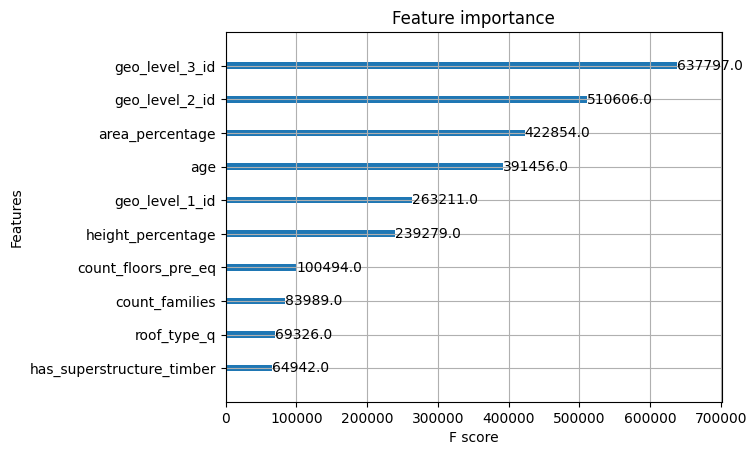

In [76]:
# XGBoost 1
xgboost.plot_importance(xgb_raw1, title='Feature importance', xlabel='F score', ylabel='Features',
                        importance_type='weight', max_num_features=10)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

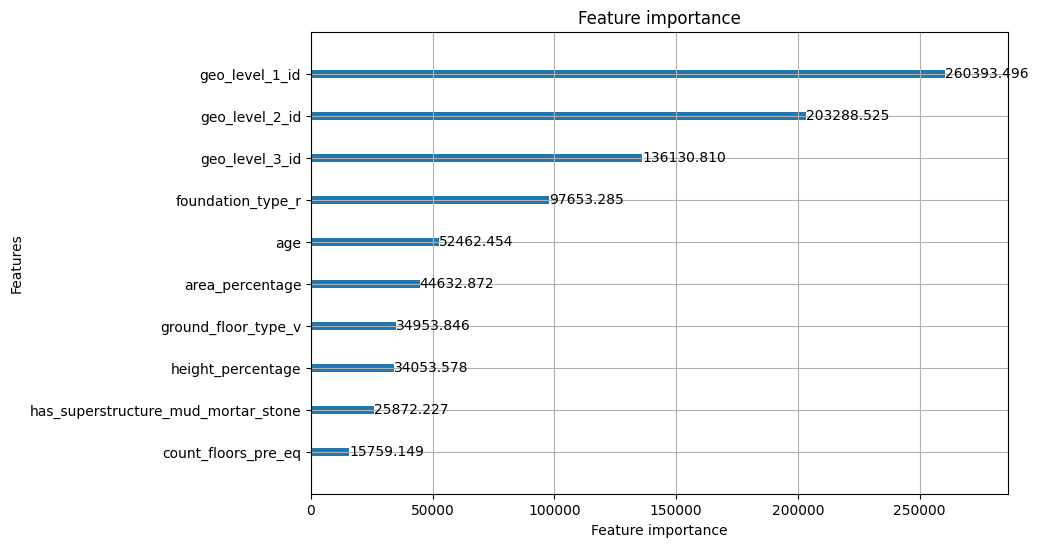

In [83]:
# LightGBM
lightgbm.plot_importance(lgbm_final, title='Feature importance', xlabel='Feature importance', ylabel='Features',
                        max_num_features=10, figsize=(9, 6))

In [84]:
# CatBoost
catb_feature_importances = list(zip(X.columns, catb_final.get_feature_importance()))
catb_importance = pd.DataFrame(catb_feature_importances, columns = ["Feature", "Importance"])
catb_importance_sorted = catb_importance.sort_values('Importance', ascending=False)
print(catb_importance_sorted.head(10))

                                Feature  Importance
0                        geo_level_1_id   36.431412
1                        geo_level_2_id   12.065161
2                        geo_level_3_id    6.850884
41                  ground_floor_type_v    5.872352
34                    foundation_type_r    5.656823
4                                   age    5.295724
8   has_superstructure_mud_mortar_stone    3.010614
6                     height_percentage    2.733608
5                       area_percentage    2.610370
3                   count_floors_pre_eq    1.696218


### 7.1.2 Prediction Comparation

In [ ]:
# xgb_raw1 (0.7497) cv: 0.7484391919782032

# xgb_raw2 (0.7487)  cv: 0.7480823246126483

# xgb_smo1_1 (0.7492)  cv: 0.7479710417769692

# xgb_smo2_1 (0.7488)  cv: 0.7480209240075889

# xgb_smo3_1 (0.7494)   cv: 0.7481360439945641

# lgbm_final (0.7470)   cv: 0.7453501781372033 #

# catb_final (0.7461)   cv: 0.746382405260632 #

In [85]:
# Compare 5 xgboost models
xgb_5_predictions = np.column_stack((y_pred_xgb_test1, y_pred_xgb_test2, y_pred_xgb_smo_test1_1,
                                   y_pred_xgb_smo_test2_1, y_pred_xgb_smo_test3_1))
xgb_5different_predictions = np.sum(np.ptp(xgb_5_predictions, axis=1) != 0)
xgb_5percentage_different = xgb_5different_predictions / len(X_test) * 100
print(f"{xgb_5percentage_different:.2f}% of the examples were disputed")

5.27% of the examples were disputed


In [90]:
# Compare 5 xgboost models with lightgbm
xgb_lgbm_predictions = np.column_stack((y_pred_xgb_test1, y_pred_xgb_test2, y_pred_xgb_smo_test1_1,
                                        y_pred_xgb_smo_test2_1, y_pred_xgb_smo_test3_1,
                                        y_pred_lgbm_test))
xgb_lgbm_different_predictions = np.sum(np.ptp(xgb_lgbm_predictions, axis=1) != 0)
xgb_lgbm_percentage_different = xgb_lgbm_different_predictions / len(X_test) * 100
print(f"{xgb_lgbm_percentage_different:.2f}% of the examples were disputed")

8.34% of the examples were disputed


In [89]:
# Compare 5 xgboost models with catboost
xgb_catb_predictions = np.column_stack((y_pred_xgb_test1, y_pred_xgb_test2, y_pred_xgb_smo_test1_1,
                                        y_pred_xgb_smo_test2_1, y_pred_xgb_smo_test3_1,
                                        y_pred_catb_test))
xgb_catb_different_predictions = np.sum(np.ptp(xgb_catb_predictions, axis=1) != 0)
xgb_catb_percentage_different = xgb_catb_different_predictions / len(X_test) * 100
print(f"{xgb_catb_percentage_different:.2f}% of the examples were disputed")

7.50% of the examples were disputed


In [91]:
# Compare all the models
all_predictions = np.column_stack((y_pred_xgb_test1, y_pred_xgb_test2, y_pred_xgb_smo_test1_1,
                                        y_pred_xgb_smo_test2_1, y_pred_xgb_smo_test3_1,
                                         y_pred_lgbm_test,y_pred_catb_test))
all_different_predictions = np.sum(np.ptp(all_predictions, axis=1) != 0)
all_percentage_different = all_different_predictions / len(X_test) * 100
print(f"{all_percentage_different:.2f}% of the examples were disputed")

9.73% of the examples were disputed


## 7.2 Ensemble methods
Voting Classifier

In [92]:
best_params_xgb1 = {'learning_rate': 0.017346885513848748, 'n_estimators': 1936, 'max_depth': 11, 'reg_alpha': 6.15864249387113e-05, 'colsample_bytree': 0.8769225093489029, 'subsample': 0.829237804768505}
clf1_xgb = XGBClassifier(**best_params_xgb1,
                  booster='gbtree',
                  objective='multi:softmax',
                  num_class=3,
                  tree_method='gpu_hist',
                  eval_metric='mlogloss'
                    )

best_params_xgb2 = {'learning_rate': 0.03467053985279808, 'n_estimators': 1377, 'max_depth': 10, 'reg_alpha': 1.2980658054156848e-05, 'colsample_bytree': 0.7689946728808666, 'subsample': 0.755867039100733}
clf2_xgb = XGBClassifier(**best_params_xgb2,
                  booster='gbtree',
                  objective='multi:softmax',
                  num_class=3,
                  tree_method='gpu_hist',
                  eval_metric='mlogloss'
                    )

best_params_xgb_smo1 = {'learning_rate': 0.03559203576734761, 'n_estimators': 1956, 'max_depth': 9, 'reg_alpha': 0.004653908666924504, 'colsample_bytree': 0.7627950008653521, 'subsample': 0.9542948474390538}
clf3_xgb = XGBClassifier(**best_params_xgb_smo1,
                  booster='gbtree',
                  objective='multi:softmax',
                  num_class=3,
                  tree_method='gpu_hist',
                  eval_metric='mlogloss'
                    )

best_params_xgb_smo2 = {'learning_rate': 0.04075921308267704, 'n_estimators': 1486, 'max_depth': 10, 'reg_alpha': 0.0021679861415337337, 'colsample_bytree': 0.7426273773691311, 'subsample': 0.8509433161738038}
clf4_xgb = XGBClassifier(**best_params_xgb_smo2,
                  booster='gbtree',
                  objective='multi:softmax',
                  num_class=3,
                  tree_method='gpu_hist',
                  eval_metric='mlogloss'
                    )

best_params_xgb_smo3 = {'learning_rate': 0.0323677327359839, 'n_estimators': 2080, 'max_depth': 9, 'reg_alpha': 0.0001915742662671955, 'colsample_bytree': 0.7883220623448634, 'subsample': 0.888497504945749}
clf5_xgb = XGBClassifier(**best_params_xgb_smo3,
                  booster='gbtree',
                  objective='multi:softmax',
                  num_class=3,
                  tree_method='gpu_hist',
                  eval_metric='mlogloss'
                    )


In [93]:
best_params_lgbm = {'learning_rate': 0.10315109529721578, 'n_estimators': 209, 'reg_alpha': 0.7522397931038659, 'reg_lambda': 8.859106416855032e-05, 'num_leaves': 330, 'colsample_bytree': 0.7710487881722415, 'subsample': 0.7832336808768992, 'subsample_freq': 8, 'min_child_samples': 108}
clf6_lgbm = LGBMClassifier(**best_params_lgbm,
                        boosting_type='gbdt',
                        objective='multiclass',
                        importance_type='gain',
                        n_jobs=-1
                        )

best_params_catb = {'learning_rate': 0.1701860262576751, 'n_estimators': 2372, 'max_depth': 9, 'random_strength': 3.5159450613172742, 'l2_leaf_reg': 95.64890630394206, 'border_count': 244, 'rsm': 0.9445925873923297, 'bagging_temperature': 0.5595400118816645}
clf7_catb = CatBoostClassifier(**best_params_catb,
                         loss_function='MultiClass',
                         grow_policy='Depthwise',
                         verbose=False,
                         classes_count=3
                         )


### 7.2.1 Hard Voting

In [26]:
# Hard Voting 1 (use 5 xgboost models with different hyperparameters)

hard_voting_clf1 = VotingClassifier(estimators=[('xgboost1',clf1_xgb),('xgboost2',clf2_xgb),('xgboost3', clf3_xgb),('xgboost4',clf4_xgb),('xgboost5',clf5_xgb)],
                                  voting='hard', n_jobs=-1
                                  )

hard_voting_clf1.fit(X, y_new)

hard_pred_test1 = hard_voting_clf1.predict(X_test)
hard_pred_test1 = hard_pred_test1 + 1

# Submission
submission_hardvoting1 = pd.DataFrame(data=hard_pred_test1,
                             columns=submission_format.columns,
                             index=submission_format.index)

submission_hardvoting1.to_csv('hardvoting1.csv')
# 0.7499

### 7.2.2 Soft Voting

In [23]:
# Soft Voting 1 (use 5 xgboost models with different hyperparameters)
soft_voting_clf1 = VotingClassifier(estimators=[('xgboost1',clf1_xgb),('xgboost2',clf2_xgb),('xgboost3', clf3_xgb),('xgboost4',clf4_xgb),('xgboost5',clf5_xgb)],
                                  voting='soft', n_jobs=-1, flatten_transform=True
                                  )

soft_voting_clf1.fit(X, y_new)

soft_pred_test1 = soft_voting_clf1.predict(X_test)
soft_pred_test1 = soft_pred_test1 + 1

# Submission
submission_softvoting1 = pd.DataFrame(data=soft_pred_test1,
                             columns=submission_format.columns,
                             index=submission_format.index)

submission_softvoting1.to_csv('softvoting1.csv')
# 0.7502 !!

In [97]:
# Soft Voting 2 (use 5 xgboost models with different hyperparameters + catboost)
soft_voting_clf2 = VotingClassifier(estimators=[('xgboost1',clf1_xgb),('xgboost2',clf2_xgb),('xgboost3', clf3_xgb),('xgboost4',clf4_xgb),('xgboost5',clf5_xgb),
                                                ('catboost',clf7_catb)],
                                  voting='soft', n_jobs=-1, flatten_transform=True
                                  )

soft_voting_clf2.fit(X, y_new)

soft_pred_test2 = soft_voting_clf2.predict(X_test)
soft_pred_test2 = soft_pred_test2 + 1

# Submission
submission_softvoting2 = pd.DataFrame(data=soft_pred_test2,
                             columns=submission_format.columns,
                             index=submission_format.index)

submission_softvoting2.to_csv('softvoting2.csv')
# 0.7496

In [31]:
# Soft Voting 3 (use 5 xgboost models with different hyperparameters + lightgbm)
soft_voting_clf3 = VotingClassifier(estimators=[('xgboost1',clf1_xgb),('xgboost2',clf2_xgb),('xgboost3', clf3_xgb),('xgboost4',clf4_xgb),('xgboost5',clf5_xgb),
                                                ('lightgbm', clf6_lgbm)],
                                  voting='soft', n_jobs=-1, flatten_transform=True
                                  )

soft_voting_clf3.fit(X, y_new)

soft_pred_test3 = soft_voting_clf3.predict(X_test)
soft_pred_test3 = soft_pred_test3 + 1

# Submission
submission_softvoting3 = pd.DataFrame(data=soft_pred_test3,
                             columns=submission_format.columns,
                             index=submission_format.index)

submission_softvoting3.to_csv('softvoting3.csv')
# 0.7502 !!

In [32]:
# Soft Voting 4 (use 5 xgboost models with different hyperparameters + lightgbm + catboost)
soft_voting_clf4 = VotingClassifier(estimators=[('xgboost1',clf1_xgb),('xgboost2',clf2_xgb),('xgboost3', clf3_xgb),('xgboost4',clf4_xgb),('xgboost5',clf5_xgb),
                                                ('lightgbm',clf6_lgbm),('catboost',clf7_catb)],
                                  voting='soft', n_jobs=-1, flatten_transform=True
                                  )

soft_voting_clf4.fit(X, y_new)

soft_pred_test4 = soft_voting_clf4.predict(X_test)
soft_pred_test4 = soft_pred_test4 + 1

# Submission
submission_softvoting4 = pd.DataFrame(data=soft_pred_test4,
                             columns=submission_format.columns,
                             index=submission_format.index)

submission_softvoting4.to_csv('softvoting4.csv')
# 0.7497